In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import pywt
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [9]:
idle_frames_number = 1039
running_frames_number = 3408
stairs_frames_number = 165
walking_frames_number = 1850

In [10]:
idle_dfs = list()
running_dfs = list()
stairs_dfs = list()
walking_dfs = list()

for i in range(1, idle_frames_number + 1):
    idle_dfs.append(pd.read_csv(f'finalProject/data/idle/idle-{i}.csv'))
    
for i in range(1, running_frames_number + 1):
    running_dfs.append(pd.read_csv(f'finalProject/data/running/running-{i}.csv'))
    
for i in range(1, stairs_frames_number + 1):
    stairs_dfs.append(pd.read_csv(f'finalProject/data/stairs/stairs-{i}.csv'))
    
for i in range(1, walking_frames_number + 1):
    walking_dfs.append(pd.read_csv(f'finalProject/data/walking/walking-{i}.csv'))

In [11]:
len(idle_dfs), len(running_dfs), len(stairs_dfs), len(walking_dfs)

(1039, 3408, 165, 1850)

In [12]:
idle_df = pd.concat(idle_dfs)
running_df = pd.concat(running_dfs)
stairs_df = pd.concat(stairs_dfs)
walking_df = pd.concat(walking_dfs)

idle_df['type'] = 'idle'
running_df['type'] = 'running'
stairs_df['type'] = 'stairs'
walking_df['type'] = 'walking'

In [13]:
global_df = pd.concat([idle_df, running_df, stairs_df, walking_df])

In [14]:
print(global_df.shape)
global_df.head()

(193860, 4)


,accelerometer_X,accelerometer_Y,accelerometer_Z,type
0,1.000776,4.616021,8.576031,idle
1,0.718261,4.209007,8.446744,idle
2,-0.909797,-0.282516,9.203311,idle
3,5.099650,0.148441,8.418014,idle
4,1.762132,-0.162806,9.251195,idle


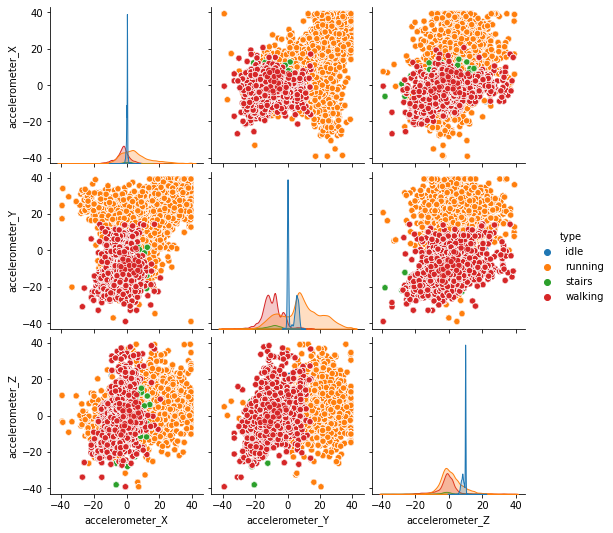

In [67]:
sns.pairplot(global_df, hue='type')

Well, only from this pair plot we can see how our data are distributed. We can see that all of the datasets (except for stairs) are almost normally distributed. Moreover idle dataset has one big spike (the main reason because it has similar data)

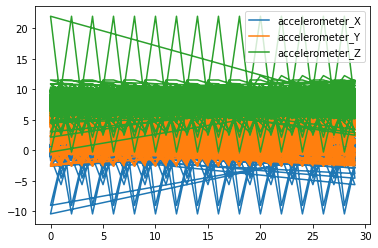

In [68]:
idle_df.plot()
plt.show()

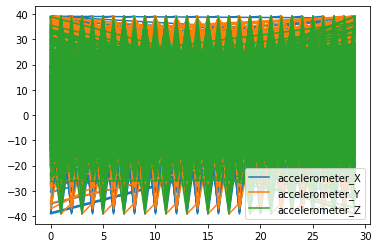

In [69]:
running_df.plot()
plt.show()

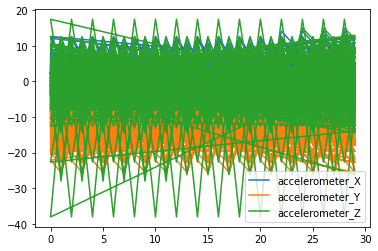

In [70]:
stairs_df.plot()
plt.show()

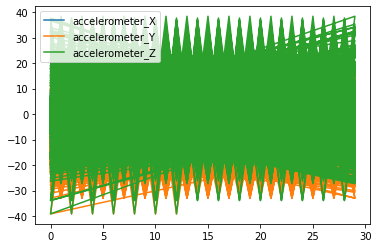

In [76]:
walking_df.plot()
plt.show()

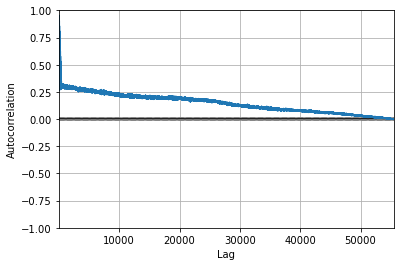

In [120]:
walking_X = walking_df.drop('type', 1)
walking_Y = walking_df['type']
autocorrelation_plot(walking_X)
plt.show()

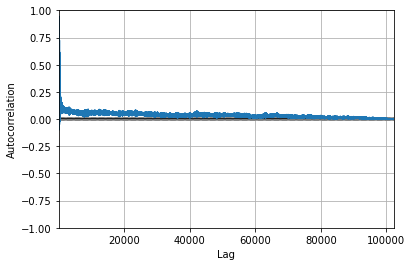

In [73]:
running_X = running_df.drop('type', 1)
running_Y = running_df['type']
autocorrelation_plot(running_df)
plt.show()

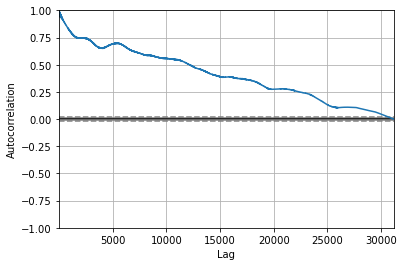

In [80]:
idle_X = idle_df.drop('type', 1)
idle_y = idle_df['type']
autocorrelation_plot(idle_X)
plt.show()

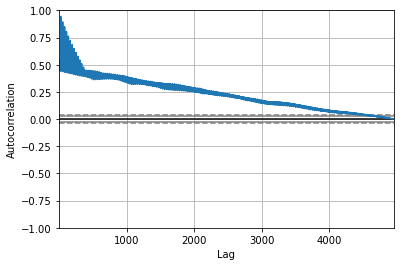

In [81]:
stairs_X = stairs_df.drop('type', 1)
stairs_Y = stairs_df['type']
autocorrelation_plot(stairs_X)
plt.show()

Let's try to make Simple Models and see how they work

In [84]:
X_global = global_df.drop('type', 1)
Y_global = global_df['type']
Xtrain, Xtest, ytrain, ytest = train_test_split(X_global, Y_global)

In [87]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X= Xtrain, y= ytrain)
y_model = model.predict(Xtest)
print(accuracy_score(y_pred= y_model, y_true= ytest))

0.854204064789023


In [106]:
from sklearn import mixture
model = mixture.GaussianMixture(n_components=4)
model.fit(X_global)
y_gmm = model.predict(X_global)

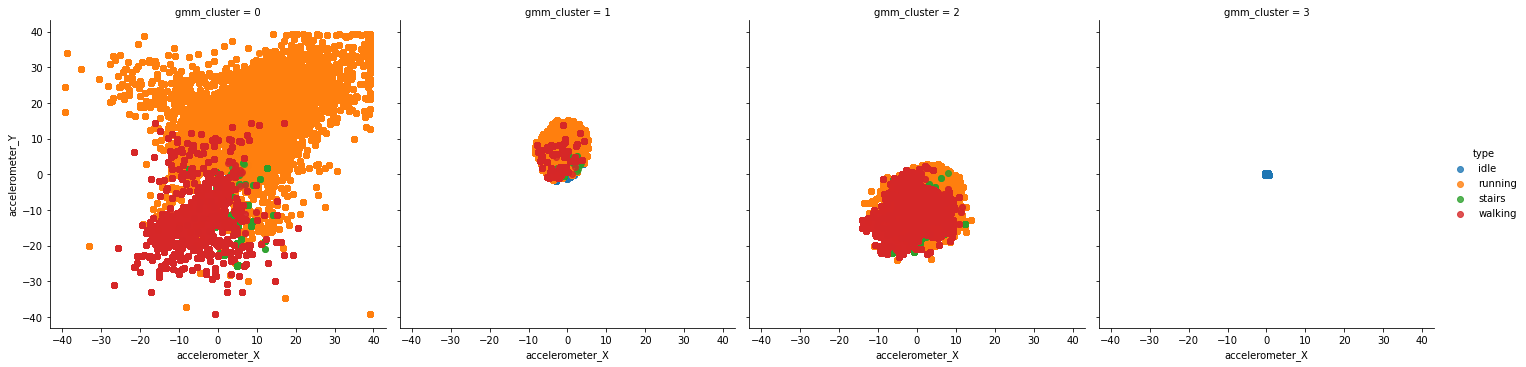

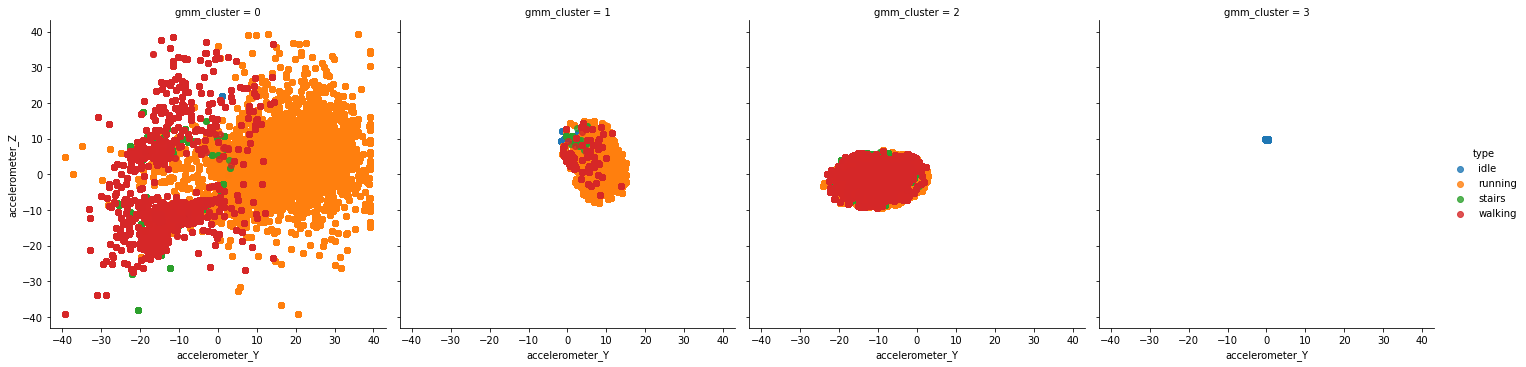

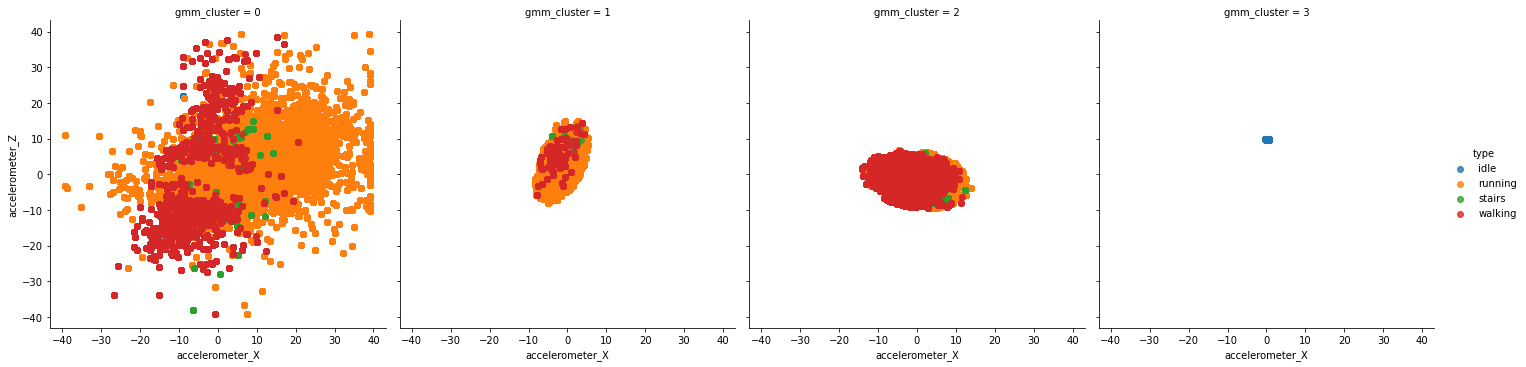

In [107]:
global_df_gmm = global_df.copy()
global_df_gmm['gmm_cluster'] = y_gmm
# sns.pairplot(global_df_gmm, hue='type')
sns.lmplot(x='accelerometer_X', y='accelerometer_Y', data= global_df_gmm, col='gmm_cluster', hue='type', fit_reg=False)
sns.lmplot(x='accelerometer_Y', y='accelerometer_Z', data= global_df_gmm, col='gmm_cluster', hue='type', fit_reg=False)
sns.lmplot(x='accelerometer_X', y='accelerometer_Z', data= global_df_gmm, col='gmm_cluster', hue='type', fit_reg=False)

Well, this result may be used for some rough systems. However, we cannot afford to rely on it if we need high precision. So, let's try to analyze this data as a timeseries

In [183]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

label_encoder = LabelEncoder()
Y = global_df['type']
Y_global = np.array(label_encoder.fit_transform(Y.values.tolist()))
global_df['type'] = Y_global

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(global_df.values)

In [261]:
X_global = global_df.drop('type', 1)
Y_global = global_df['type']
X_train, X_test, y_train, y_test = train_test_split(X_global, Y_global)
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [248]:
regressor = Sequential()
regressor.add(LSTM( units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1) ))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 100, batch_size = 32)

Epoch 1/100
4544/4544 [==============================] - 31s 6ms/step - loss: 0.3253 - val_loss: 0.2441
Epoch 2/100
4544/4544 [==============================] - 25s 6ms/step - loss: 0.2538 - val_loss: 0.2351
Epoch 3/100
4544/4544 [==============================] - 27s 6ms/step - loss: 0.2397 - val_loss: 0.2206
Epoch 4/100
4544/4544 [==============================] - 25s 6ms/step - loss: 0.2323 - val_loss: 0.2188
Epoch 5/100
4544/4544 [==============================] - 25s 6ms/step - loss: 0.2267 - val_loss: 0.2109
Epoch 6/100
4544/4544 [==============================] - 25s 6ms/step - loss: 0.2233 - val_loss: 0.2100
Epoch 7/100
4544/4544 [==============================] - 25s 6ms/step - loss: 0.2205 - val_loss: 0.2081
Epoch 8/100
4544/4544 [==============================] - 25s 6ms/step - loss: 0.2169 - val_loss: 0.2046
Epoch 9/100
4544/4544 [==============================] - 25s 6ms/step - loss: 0.2148 - val_loss: 0.2034
Epoch 10/100
4544/4544 [==============================] - 26s 6m

4544/4544 [==============================] - 27s 6ms/step - loss: 0.1471 - val_loss: 0.1182
Epoch 80/100
4544/4544 [==============================] - 27s 6ms/step - loss: 0.1472 - val_loss: 0.1190
Epoch 81/100
4544/4544 [==============================] - 27s 6ms/step - loss: 0.1470 - val_loss: 0.1181
Epoch 82/100
4544/4544 [==============================] - 27s 6ms/step - loss: 0.1459 - val_loss: 0.1217
Epoch 83/100
4544/4544 [==============================] - 27s 6ms/step - loss: 0.1450 - val_loss: 0.1171
Epoch 84/100
4544/4544 [==============================] - 27s 6ms/step - loss: 0.1448 - val_loss: 0.1153
Epoch 85/100
4544/4544 [==============================] - 27s 6ms/step - loss: 0.1442 - val_loss: 0.1172
Epoch 86/100
4544/4544 [==============================] - 27s 6ms/step - loss: 0.1436 - val_loss: 0.1162
Epoch 87/100
4544/4544 [==============================] - 27s 6ms/step - loss: 0.1447 - val_loss: 0.1200
Epoch 88/100
4544/4544 [==============================] - 27s 6ms/st

In [250]:
predicted = regressor.predict(X_test)

By applying the LSTM model, we've got a model with a 0.8887 accuracy score. It is a better result than we get with GaussianNB but still not perfect. I guess we can improve this result in 2 ways:
1) We can create a model by using Continuous Wavelet Transformation, wich is better for time series data with repeating activity such a running/idle/walking/etc

2) Remove the stairs dataset because it has only 165 examples. Or add more data examples to it.

In [255]:
from skimage.transform import resize

def create_cwt_images(X, n_scales, rescale_size, wavelet_name = "morl"):
    n_samples = X.shape[0] 
    n_signals = X.shape[2] 
    
    # range of scales from 1 to n_scales
    scales = np.arange(1, n_scales + 1) 
    
    # pre allocate array
    X_cwt = np.ndarray(shape=(n_samples, rescale_size, rescale_size, n_signals), dtype = 'float32')
    
    for sample in range(n_samples):
        if sample % 1000 == 0:
            print(sample)
        for signal in range(n_signals):
            serie = X[sample, :, signal]
            # continuous wavelet transform 
            coeffs, freqs = pywt.cwt(serie, scales, wavelet_name)
            # resize the 2D cwt coeffs
            rescale_coeffs = resize(coeffs, (rescale_size, rescale_size), mode = 'constant')
            X_cwt[sample,:,:,signal] = rescale_coeffs
            
    return X_cwt
  
# amount of pixels in X and Y 
rescale_size = 64
# determine the max scale size
n_scales = 64

X_train_cwt = create_cwt_images(X_train, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: {X_train_cwt.shape}")
X_test_cwt = create_cwt_images(X_test, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: {X_test_cwt.shape}")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: (145395, 64, 64, 1)
0
1000
2000
300

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

def build_cnn_model(activation, input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, 5, activation = activation, padding = 'same', input_shape = input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 5, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(MaxPooling2D())  
    model.add(Flatten())
    
    model.add(Dense(128, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(54, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(4, activation = 'softmax'))
    
    print(model.summary())
    return model

def compile_and_fit_model(model, X_train, y_train, X_test, y_test, batch_size, n_epochs):

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])
    
    callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_sparse_categorical_accuracy', save_best_only=True)]
    
    history = model.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))
    
    return model, history

input_shape = (X_train_cwt.shape[1], X_train_cwt.shape[2], X_train_cwt.shape[3])

cnn_model = build_cnn_model("relu", input_shape)
trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, X_train_cwt, y_train, X_test_cwt, y_test, 368, 5)

As we see, we got only 90% of confidence even by using CWT. Let's try to remove stairs out of data and test with a simple model.

In [257]:
test_global_df = pd.concat([idle_df, running_df, walking_df])

In [259]:
from sklearn.naive_bayes import GaussianNB
X_global = global_df.drop('type', 1)
Y_global = global_df['type']
Xtrain, Xtest, ytrain, ytest = train_test_split(X_global, Y_global)
model = GaussianNB()
model.fit(X= Xtrain, y= ytrain)
y_model = model.predict(Xtest)
print(accuracy_score(y_pred= y_model, y_true= ytest))

0.855194470236253


Previously we got 0.8542% and now it's 0.85519%. So probably removing of stairs wont help

**Results**

We tried to build a model that would classify the activity of users by parameters in XYZ coordinate space. Models that we got have accuracy up to 90%. After comparing different models methods, we can conclude that Continuous Wavelet Transformation has the best accuracy for our task.